In [1]:
from __future__ import print_function,division
from keras.layers import  Input, Bidirectional,LSTM,Dense,Dropout,Concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Embedding
import cPickle as pickle
from matplotlib import pyplot
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import regularizers
import psutil
import numpy as np
import nltk

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
psutil.virtual_memory()

svmem(total=8240300032, available=6276726784, percent=23.8, used=1454915584, free=5775212544, active=1644228608, inactive=547295232, buffers=145027072, cached=865144832, shared=225828864)

In [3]:
#FN1='embeddingReviewsFilewithOtherdata'
FN2='myPaddedDataFile'

In [4]:
with open('%s.pkl'%FN2,'rb') as fp:
    embeddingReviews, modiefiedSummaryWord_index,myPaddedData= pickle.load(fp)

In [5]:
psutil.virtual_memory()

svmem(total=8240300032, available=6248656896, percent=24.2, used=1483046912, free=5701271552, active=1703727104, inactive=560738304, buffers=168669184, cached=887312384, shared=225832960)

In [6]:
paddedReviews=myPaddedData['paddedReviews']
paddedSummary=myPaddedData['paddedSummary']
paddedModifiedSummary=myPaddedData['paddedModifiedSummary']
testPaddedReviews=myPaddedData['testPaddedReviews']
testPaddedSummary=myPaddedData['testPaddedSummary']

In [7]:
TrainingDataIX=paddedReviews
TrainingDataTY=paddedSummary
TrainingDataIY=paddedModifiedSummary
TrainingDataIX.shape,TrainingDataIY.shape,TrainingDataTY.shape

((1250, 200), (1250, 30), (1250, 30))

In [8]:
TestDataIX=testPaddedReviews
TestDataTY=testPaddedSummary

In [9]:
psutil.virtual_memory()

svmem(total=8240300032, available=6248546304, percent=24.2, used=1483259904, free=5700833280, active=1703903232, inactive=560889856, buffers=168710144, cached=887496704, shared=225832960)

In [10]:
nb_samples=len(TrainingDataIX)
nb_samples

1250

In [11]:
ModifiedVocabSize=len(modiefiedSummaryWord_index)


In [12]:
ModifiedVocabSize

6617

In [13]:
psutil.virtual_memory()

svmem(total=8240300032, available=6248501248, percent=24.2, used=1483436032, free=5700165632, active=1704587264, inactive=560951296, buffers=168751104, cached=887947264, shared=225832960)

In [14]:
decoderInputSummary=to_categorical(paddedModifiedSummary,num_classes=ModifiedVocabSize)

In [15]:
decoderInputSummary=decoderInputSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [16]:
decoderInputSummary.shape

(1250, 30, 6617)

In [17]:
psutil.virtual_memory()

svmem(total=8240300032, available=4262551552, percent=48.3, used=3469385728, free=3714215936, active=3686981632, inactive=560951296, buffers=168783872, cached=887914496, shared=225832960)

In [18]:
#FN2='CtegoricalSummaryData'

In [19]:
decoderTargetSummary=to_categorical(paddedSummary,num_classes=ModifiedVocabSize)

In [20]:
decoderTargetSummary.shape

(1250, 30, 6617)

In [21]:
decoderTargetSummary=decoderTargetSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [22]:
decoderTargetSummary.shape

(1250, 30, 6617)

In [23]:
psutil.virtual_memory()

svmem(total=8240300032, available=2274787328, percent=72.4, used=5457149952, free=1726451712, active=5671088128, inactive=560951296, buffers=168824832, cached=887873536, shared=225832960)

In [24]:
#valOneHotSummary=to_categorical(valPaddedSummary,num_classes=ModifiedVocabSize)

In [25]:
with open('%s.pkl'%'embeddingReviewsFile', 'rb') as fp:
    embeddingReviews = pickle.load(fp)

In [26]:
embedding_dim=100

In [27]:
ReviewsVocabSize=32251#30172#27789
maxReviewLength=200
maxSummaryLength=30

In [28]:
#Encoder
Encoder_embedding_layer = Embedding(ReviewsVocabSize,
                            embedding_dim,
                            weights=[embeddingReviews],
                            input_length=maxReviewLength,
                            trainable=True,
                            mask_zero=True)
encoder_input=Input(shape=(maxReviewLength,))
print('encoder_input shape is:->',encoder_input.shape)
embedded_Encoder_inputSequence=Encoder_embedding_layer(encoder_input)
encoder_LSTM=Bidirectional(LSTM(50, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_LSTM(embedded_Encoder_inputSequence)
encoder_h= Concatenate()([forward_h, backward_h])
encoder_c = Concatenate()([forward_c, backward_c])

#print(type(encoder_LSTM))
#encoder_output,encoder_h,encoder_c=encoder_LSTM(embedded_Encoder_inputSequence)
#print('encoder_output shape:->',encoder_output.shape)
encoder_states=[encoder_h,encoder_c]

encoder_input shape is:-> (?, 200)


In [29]:
decoder_input=Input(shape=(None,ModifiedVocabSize))
decoder_LSTM=LSTM(100,return_sequences=True, return_state = True,dropout=0.35,recurrent_dropout=0.25,recurrent_regularizer=regularizers.l2(0.0532))#,recurrent_dropout=0.25,bias_regularizer=regularizers.l2(0.02),recurrent_regularizer=regularizers.l2(0.02))
decoder_output,decoder_h,decoder_c=decoder_LSTM(decoder_input,initial_state=encoder_states)
final_decoder_out=Dense(ModifiedVocabSize,activation='softmax',kernel_regularizer=regularizers.l1(0.02),activity_regularizer=regularizers.l2(0.02)#,kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l2(0.06)
                       )(decoder_output)
final_decoder_out=Dropout(0.45)(final_decoder_out)

In [30]:
model=Model(inputs=[encoder_input,decoder_input],output=final_decoder_out)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("dr..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [31]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999,decay=0.004)
#opt=sgd(lr=0.001, momentum=0.2, decay=0.1, nesterov=False)
#opt=Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
#filepath="summWithoutAttention.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=False, mode='auto', period=1)
checkpointer = ModelCheckpoint(filepath='SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5', verbose=1, save_best_only=False,mode='auto',period=1)
#es=EarlyStopping(patience=5)
#callbacks_list = [checkpoint]

In [32]:
#model.load_weights('SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5')

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     3225100     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 100), (None, 60400       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6617)   0                                            
__________________________________________________________________________________________________
concatenat

In [34]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [35]:
history=model.fit(x=[TrainingDataIX,decoderInputSummary], 
          y=decoderTargetSummary,
          batch_size=64,
          epochs=800,
          validation_split=0.2,callbacks=[checkpointer])#,es])

Train on 1000 samples, validate on 250 samples
Epoch 1/800
1000/1000 [==============================] - 93s 93ms/step - loss: 76.4740 - acc: 0.1206 - val_loss: 40.9348 - val_acc: 0.3121

Epoch 00001: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/800
1000/1000 [==============================] - 92s 92ms/step - loss: 35.9192 - acc: 0.1842 - val_loss: 23.4048 - val_acc: 0.3121

Epoch 00002: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 3/800
1000/1000 [==============================] - 92s 92ms/step - loss: 27.7344 - acc: 0.1838 - val_loss: 22.1391 - val_acc: 0.3121

Epoch 00003: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 4/800
1000/1000 [==============================] - 93s 93ms/step - loss: 25.6211 - acc: 0.1785 - val_loss: 22.3476 - val_acc: 0.3121

Epoch 00004: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 5/800
1000/1000 [==============================] - 93s 93ms/step - loss: 24.3293 - acc: 0.1805 - val_loss: 19.7865 - val_acc: 0.3121

Epoch 00005: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 6/800
1000/1000 [==============================] -

Epoch 37/800
1000/1000 [==============================] - 93s 93ms/step - loss: 14.4250 - acc: 0.1951 - val_loss: 10.3212 - val_acc: 0.3177

Epoch 00037: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 38/800
1000/1000 [==============================] - 92s 92ms/step - loss: 14.3674 - acc: 0.1930 - val_loss: 10.2030 - val_acc: 0.3187

Epoch 00038: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 39/800
1000/1000 [==============================] - 93s 93ms/step - loss: 14.2845 - acc: 0.1913 - val_loss: 10.1325 - val_acc: 0.3205

Epoch 00039: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 40/800
1000/1000 [==============================] - 92s 92ms/step - loss: 14.1492 - acc: 0.1959 - val_loss: 10.0565 - val_acc: 0.3172

Epoch 00040: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 41/800
1000/1000 [============================

Epoch 72/800
1000/1000 [==============================] - 94s 94ms/step - loss: 12.6834 - acc: 0.1983 - val_loss: 8.5777 - val_acc: 0.3087

Epoch 00072: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 73/800
1000/1000 [==============================] - 96s 96ms/step - loss: 12.7539 - acc: 0.1951 - val_loss: 8.5627 - val_acc: 0.3049

Epoch 00073: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 74/800
1000/1000 [==============================] - 94s 94ms/step - loss: 12.6930 - acc: 0.1971 - val_loss: 8.5458 - val_acc: 0.3021

Epoch 00074: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 75/800
1000/1000 [==============================] - 94s 94ms/step - loss: 12.6416 - acc: 0.1996 - val_loss: 8.4956 - val_acc: 0.3092

Epoch 00075: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 76/800
1000/1000 [==============================] 

Epoch 107/800
1000/1000 [==============================] - 93s 93ms/step - loss: 12.0716 - acc: 0.1948 - val_loss: 7.9244 - val_acc: 0.2983

Epoch 00107: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 108/800
1000/1000 [==============================] - 93s 93ms/step - loss: 11.9594 - acc: 0.1990 - val_loss: 7.9055 - val_acc: 0.2984

Epoch 00108: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 109/800
1000/1000 [==============================] - 92s 92ms/step - loss: 11.9274 - acc: 0.2025 - val_loss: 7.8829 - val_acc: 0.2992

Epoch 00109: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 110/800
1000/1000 [==============================] - 94s 94ms/step - loss: 12.0279 - acc: 0.1944 - val_loss: 7.8651 - val_acc: 0.3003

Epoch 00110: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 111/800
1000/1000 [===========================


Epoch 00141: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 142/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.5848 - acc: 0.2002 - val_loss: 7.5356 - val_acc: 0.2985

Epoch 00142: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 143/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.5870 - acc: 0.1987 - val_loss: 7.5313 - val_acc: 0.2959

Epoch 00143: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 144/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.6337 - acc: 0.1966 - val_loss: 7.5287 - val_acc: 0.2967

Epoch 00144: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 145/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.5908 - acc: 0.1978 - val_loss: 7.5213 - val_acc: 0.2948

Epoch 00145: saving model to SummarizationWithoutAt

1000/1000 [==============================] - 94s 94ms/step - loss: 11.3717 - acc: 0.1996 - val_loss: 7.3069 - val_acc: 0.2989

Epoch 00176: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 177/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.3664 - acc: 0.1982 - val_loss: 7.3080 - val_acc: 0.2967

Epoch 00177: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 178/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.4120 - acc: 0.1960 - val_loss: 7.3089 - val_acc: 0.2969

Epoch 00178: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 179/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.2724 - acc: 0.2024 - val_loss: 7.2946 - val_acc: 0.2981

Epoch 00179: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 180/800
1000/1000 [==============================] - 93s 93m

Epoch 211/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.2241 - acc: 0.1967 - val_loss: 7.1572 - val_acc: 0.2932

Epoch 00211: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 212/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.2083 - acc: 0.1994 - val_loss: 7.1495 - val_acc: 0.2927

Epoch 00212: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 213/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.1928 - acc: 0.1973 - val_loss: 7.1453 - val_acc: 0.2935

Epoch 00213: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 214/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.2124 - acc: 0.1968 - val_loss: 7.1403 - val_acc: 0.2972

Epoch 00214: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 215/800
1000/1000 [===========================


Epoch 00245: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 246/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.0610 - acc: 0.1971 - val_loss: 7.0333 - val_acc: 0.2939

Epoch 00246: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 247/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.0546 - acc: 0.1998 - val_loss: 7.0232 - val_acc: 0.2977

Epoch 00247: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 248/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.0917 - acc: 0.1965 - val_loss: 7.0242 - val_acc: 0.2947

Epoch 00248: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 249/800
1000/1000 [==============================] - 94s 94ms/step - loss: 11.0515 - acc: 0.1995 - val_loss: 7.0271 - val_acc: 0.2933

Epoch 00249: saving model to SummarizationWithoutAt

1000/1000 [==============================] - 95s 95ms/step - loss: 10.9977 - acc: 0.1958 - val_loss: 6.9457 - val_acc: 0.2939

Epoch 00280: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 281/800
1000/1000 [==============================] - 95s 95ms/step - loss: 10.9807 - acc: 0.1966 - val_loss: 6.9427 - val_acc: 0.2948

Epoch 00281: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 282/800
1000/1000 [==============================] - 97s 97ms/step - loss: 10.9216 - acc: 0.1998 - val_loss: 6.9365 - val_acc: 0.2959

Epoch 00282: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 283/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.9105 - acc: 0.1980 - val_loss: 6.9329 - val_acc: 0.2969

Epoch 00283: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 284/800
1000/1000 [==============================] - 94s 94m

Epoch 315/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.8506 - acc: 0.1986 - val_loss: 6.8655 - val_acc: 0.2979

Epoch 00315: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 316/800
1000/1000 [==============================] - 97s 97ms/step - loss: 10.9584 - acc: 0.1959 - val_loss: 6.8670 - val_acc: 0.2971

Epoch 00316: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 317/800
1000/1000 [==============================] - 97s 97ms/step - loss: 10.8322 - acc: 0.2000 - val_loss: 6.8593 - val_acc: 0.2981

Epoch 00317: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 318/800
1000/1000 [==============================] - 94s 94ms/step - loss: 10.8363 - acc: 0.2009 - val_loss: 6.8652 - val_acc: 0.2961

Epoch 00318: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 319/800
1000/1000 [===========================


Epoch 00349: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 350/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.8789 - acc: 0.1979 - val_loss: 6.8074 - val_acc: 0.3028

Epoch 00350: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 351/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.7757 - acc: 0.2005 - val_loss: 6.8090 - val_acc: 0.3009

Epoch 00351: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 352/800
1000/1000 [==============================] - 98s 98ms/step - loss: 10.7758 - acc: 0.1994 - val_loss: 6.8045 - val_acc: 0.3024

Epoch 00352: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 353/800
1000/1000 [==============================] - 98s 98ms/step - loss: 10.7529 - acc: 0.1977 - val_loss: 6.8055 - val_acc: 0.3011

Epoch 00353: saving model to SummarizationWithoutAt

1000/1000 [==============================] - 100s 100ms/step - loss: 10.7883 - acc: 0.1940 - val_loss: 6.7646 - val_acc: 0.3025

Epoch 00384: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 385/800
1000/1000 [==============================] - 97s 97ms/step - loss: 10.7517 - acc: 0.1958 - val_loss: 6.7567 - val_acc: 0.3051

Epoch 00385: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 386/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.7824 - acc: 0.1981 - val_loss: 6.7637 - val_acc: 0.3017

Epoch 00386: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 387/800
1000/1000 [==============================] - 98s 98ms/step - loss: 10.7911 - acc: 0.1938 - val_loss: 6.7689 - val_acc: 0.3004

Epoch 00387: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 388/800
1000/1000 [==============================] - 97s 9

Epoch 419/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.8069 - acc: 0.1939 - val_loss: 6.7273 - val_acc: 0.3033

Epoch 00419: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 420/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.7336 - acc: 0.1963 - val_loss: 6.7203 - val_acc: 0.3057

Epoch 00420: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 421/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.6601 - acc: 0.1991 - val_loss: 6.7238 - val_acc: 0.3039

Epoch 00421: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 422/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.6765 - acc: 0.1992 - val_loss: 6.7231 - val_acc: 0.3033

Epoch 00422: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 423/800
1000/1000 [===========================


Epoch 00453: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 454/800
1000/1000 [==============================] - 99s 99ms/step - loss: 10.6735 - acc: 0.1982 - val_loss: 6.6945 - val_acc: 0.3055

Epoch 00454: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 455/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.7334 - acc: 0.1960 - val_loss: 6.6942 - val_acc: 0.3049

Epoch 00455: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 456/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.6090 - acc: 0.2016 - val_loss: 6.6994 - val_acc: 0.3029

Epoch 00456: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 457/800
1000/1000 [==============================] - 96s 96ms/step - loss: 10.6876 - acc: 0.1992 - val_loss: 6.6920 - val_acc: 0.3048

Epoch 00457: saving model to SummarizationWithoutAt

1000/1000 [==============================] - 97s 97ms/step - loss: 10.6364 - acc: 0.1984 - val_loss: 6.6686 - val_acc: 0.3060

Epoch 00488: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 489/800
1000/1000 [==============================] - 100s 100ms/step - loss: 10.6461 - acc: 0.1962 - val_loss: 6.6724 - val_acc: 0.3039

Epoch 00489: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 490/800
1000/1000 [==============================] - 97s 97ms/step - loss: 10.6132 - acc: 0.1990 - val_loss: 6.6732 - val_acc: 0.3037

Epoch 00490: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 491/800
1000/1000 [==============================] - 101s 101ms/step - loss: 10.6178 - acc: 0.1970 - val_loss: 6.6705 - val_acc: 0.3048

Epoch 00491: saving model to SummarizationWithoutAttentionUsingBidirectionalV3.2.14Weights.hdf5
Epoch 492/800
1000/1000 [==============================] - 98s

KeyboardInterrupt: 

In [37]:
#model.load_weights('SummarizationWithoutAttentionV3.2.8Weights.hdf5')

In [37]:
#history=model.fit(x=[TrainingDataIX,decoderInputSummary], 
 #         y=decoderTargetSummary,
  #        batch_size=64,
   #       epochs=1000,
    #      initial_epoch=51,        
     #     validation_split=0.2,callbacks=[checkpointer])#,es])

In [39]:
print(history.history['acc'])

[0.17860000088065864, 0.18293333411961793, 0.18850000128149985, 0.18710000048577785, 0.19183333390951157, 0.19396666757762432, 0.19056666721403598, 0.19813333363831043, 0.1946999997794628, 0.19810000078752638, 0.1954666675031185, 0.1949666671305895, 0.19686666683852672, 0.19303333380818366, 0.19556666734814643, 0.1982666669934988, 0.1961333339959383, 0.19796666698157786, 0.19553333343565463, 0.2004666673094034, 0.19353333385288715, 0.19410000056028365, 0.19870000046491623, 0.19940000116825105, 0.19670000012218952, 0.1982000000476837, 0.19806666697561742, 0.1980666667073965, 0.19900000029802323, 0.19873333352804184, 0.19956666657328606, 0.19686666721105575, 0.19789999982714654, 0.19530000026524066, 0.1959666667878628, 0.19656666648387908, 0.19703333321213723, 0.19786666770279407, 0.19746666660904885, 0.197800000205636, 0.19603333286941052, 0.1968666667789221, 0.1977333339601755, 0.19683333376049997, 0.19880000013113022, 0.196233334004879, 0.19680000008642673, 0.19806666730344297, 0.1963

In [40]:
from matplotlib import pyplot

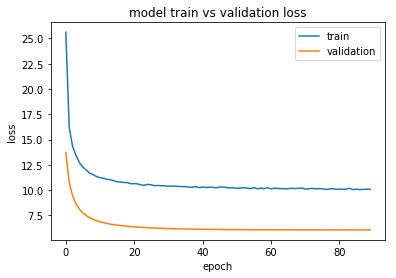

In [41]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Inferencing

In [36]:
#Encoder Inference
encoder_model_inf=Model(inputs=encoder_input,outputs=encoder_states)

In [37]:
#Decoder Inference
decoder_state_input_h=Input(shape=(100,))
decoder_state_input_c = Input(shape=(100,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]
decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input,initial_state=decoder_input_states)
decoder_states=[decoder_h,decoder_c]
#decoder_inf_out = decoder_dense_rel(decoder_out)
#decoder_inf_final_out=decoder_dense(decoder_inf_out)
#decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,outputs=[decoder_inf_final_out] + decoder_states )
decoder_inf_final_out = Dense(ModifiedVocabSize,activation='softmax'#,kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l2(0.05)
                             )(decoder_out)
#decoder_inf_final_out=Dropout(0.4)(decoder_inf_final_out)
decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_inf_final_out] + decoder_states )

In [38]:
modiefiedSummaryWord_index['SOS']

6615

In [39]:
int_to_vocab_summaries = {}
for word, value in modiefiedSummaryWord_index.items():
    int_to_vocab_summaries[value] = word

In [40]:
def decode_seq(input_seq):
    # Initial states value is coming from the encoder 
    #We get the encoder states into states_val variable
    states_val = encoder_model_inf.predict(input_seq)#return encoder states
    target_seq = np.zeros((1,1,ModifiedVocabSize))
    print('target_seq shape:->',target_seq.shape)
    target_seq[0, 0, modiefiedSummaryWord_index['SOS']] = 1
    print(target_seq.shape)
    #target_seq=embeddingModifiedSummaries[modiefiedSummaryWord_index['SOS']]
    summarized_sent = ''
    stop_condition = False
    i=1
    while not stop_condition:
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        #print(decoder_out)
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_summary_word = int_to_vocab_summaries[max_val_index]
        #print('sampled_summary_word is:->',sampled_summary_word)
        #print()
        summarized_sent += sampled_summary_word+" "
        #print('summarized_sent is:->',summarized_sent)
        #print()
        if ((sampled_summary_word == 'EOS') or (len(summarized_sent) >= maxSummaryLength)) :
            print('terminated')
            stop_condition = True
        
        target_seq = np.zeros((1,1,ModifiedVocabSize))
        target_seq[0, 0, max_val_index]=1
        
        states_val = [decoder_h, decoder_c]
        i=i+1
        
    return summarized_sent

In [41]:
human_summary=[]
for i in range(50):    
    #print('System Generated Summary:',summary)
    temp=[]
    for j in range(len(testPaddedSummary[i])):
        temp.append(int_to_vocab_summaries[testPaddedSummary[i][j]])
    human_summary.append(temp)    
humanSummary=" "        
for i in range(50):
    data=testPaddedReviews[i].reshape(1,200)
    summary=decode_seq(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    humanSummary=" "
   

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  thirteen days offers a compelling look at the cuban missile crisis and its talented cast deftly portrays the reallife people who were involved PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  the great muppet caper is overplotted and uneven but the appealing presence of kermit miss piggy and the gang ensure that this heist flick is always breezily watchable PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  a tense gripping thriller a hijacking avoids action movie cliches and instead creates a palpable sense of dread by mixing gritty realism with atmospheric beauty PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Genera

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  visually arresting but the story could be told with a bit more energy PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves weaves position position 
Human Summary  this overly silly satire aims at too many targets with arrows too dull to make relevant social commentary PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  though it is slick and stylish sorority row offers nothing new to the slasher genre and misses the mark both in its attempts at humor and thrills PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  as successful as 

In [42]:
from nltk.translate.bleu_score import sentence_bleu

In [43]:
humanSummary=" "  
scores=[]
for i in range(50):
    testData=testPaddedReviews[i].reshape(1,200)
    summary=decode_seq(testData)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    #calculation of bleu score
    score=sentence_bleu(nltk.word_tokenize(summary),nltk.word_tokenize(humanSummary)#,weights=(0.5, 0.5, 0, 0)
                       )
    print('BlEU SCORE IS:->',score)
    scores.append(score)      
    humanSummary=" "

total=0
for i in scores:
    total+=i
print('AVERAGE BLEU SCORE:->',total/len(scores))   

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  thirteen days offers a compelling look at the cuban missile crisis and its talented cast deftly portrays the reallife people who were involved PAD PAD PAD PAD PAD PAD PAD 


/usr/local/lib/python2.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  the great muppet caper is overplotted and uneven but the appealing presence of kermit miss piggy and the gang ensure that this heist flick is always breezily watchable PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  a tense gripping thriller a hijacking avoids action movie cliches and instead creates a palpable sense of dread by mixing gritty realism with atmospheric beauty PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: position position position position 
Human Summary  the rare sequel that arguably improves on its predecessor toy story 2 uses inventive storytelling gorgeous animation and a talented cast to deliver another r

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves weaves happens happens 
Human Summary  the nativity story is a dull retelling of a wellworn tale with the look and feel of a highschool production PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  elevated by finchers directorial talent and fosters performance panic room is a wellcrafted aboveaverage thriller PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  it has the schmaltzy trappings of my romantic films but like crazy allows its characters to express themselves beyond dialogue crafting a true intimate study PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target

In [44]:
human_summary=[]
for i in range(50):    
    #print('System Generated Summary:',summary)
    temp=[]
    for j in range(len(paddedSummary[i])):
        temp.append(int_to_vocab_summaries[paddedSummary[i][j]])
    human_summary.append(temp)    
humanSummary=" "        
for i in range(50):
    data=paddedReviews[i].reshape(1,200)
    summary=decode_seq(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    humanSummary=" "

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  poor plot development and slow pacing keep 54 from capturing the energy of it is legendary namesake PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  while it hews closely to the 1984 original craig brewer infuses his footloose remake with toetapping energy and manages to keep the story fresh for a new generation PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position p

terminated
System Generated Summary: weaves position position position 
Human Summary  better off dead is an anarchic mix of black humor and surreal comedy anchored by john cusacks winsome charming performance PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  while fast times at ridgemont high features sean penns legendary performance the film endures because it accurately captured the small details of school work and teenage life PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves weaves weaves weaves weaves 
Human Summary  this longoverdue return from alejandro jodorowsky finds him just as overflowing with imagination and heart as fans have come to expect PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: position position position position 
Hu

In [45]:
humanSummary=" "  
scores=[]
for i in range(50):
    testData=paddedReviews[i].reshape(1,200)
    summary=decode_seq(testData)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    #calculation of bleu score
    score=sentence_bleu(nltk.word_tokenize(summary),nltk.word_tokenize(humanSummary)#,weights=(0.5, 0.5, 0, 0)
                       )
    print('BlEU SCORE IS:->',score)
    scores.append(score)      
    humanSummary=" "

total=0
for i in scores:
    total+=i
print('AVERAGE BLEU SCORE:->',total/len(scores))

target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  poor plot development and slow pacing keep 54 from capturing the energy of it is legendary namesake PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  while it hews closely to the 1984 original craig brewer infuses his footloose remake with toetapping energy and manages to keep the story fresh for a new generation PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1,

Human Summary  planet 51 squanders an interesting premise with an overly familiar storyline stock characters and humor that alternates between curious and potentially offensive PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  in addition to its breathtaking underwater photography sharkwater has a convincing impassioned argument of how the plight of sharks affects everyone PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.427287006396
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position position position 
Human Summary  better off dead is an anarchic mix of black humor and surreal comedy anchored by john cusacks winsome charming performance PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 6617)
(1, 1, 6617)
terminated
System Generated Summary: weaves position posit

AVERAGE BLEU SCORE:-> 0.222119476346
